# Using Papermill to Execute a Digital Elevation Model and store the result in an S3 bucket

See [RFC](https://www.notion.so/sensandworkspace/RFC-Geospatial-integrations-with-a-REPL-bd5d344487234fef85e5414300e417f4) for more detail

In [1]:
#papermill_description=imports

import json
import os
import uuid
import geopandas as gpd
from io import StringIO
import pystac_client
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import boto3
from botocore.exceptions import NoCredentialsError
import time
from requests.exceptions import HTTPError
from gis_utils.stac import initialize_stac_client, query_stac_api

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
#papermill_description=init_s3_client

def init_s3_client(endpoint_url, aws_access_key_id, aws_secret_access_key, region_name):
    """
    Initialize an S3 client with the specified configuration.

    Args:
        endpoint_url (str): The complete URL to the S3 service. This is typically the URL to a mock S3 service in a local development environment.
        aws_access_key_id (str): AWS access key ID. For mock services, this can be any string, as authentication is not enforced.
        aws_secret_access_key (str): AWS secret access key. For mock services, this can be any string, as authentication is not enforced.
        region_name (str): The AWS region to use. This can be any valid AWS region string.

    Returns:
        boto3.client: A boto3 S3 client configured to interact with the specified S3 service.
    """
    return boto3.client('s3',
                        endpoint_url=endpoint_url,
                        aws_access_key_id=aws_access_key_id,
                        aws_secret_access_key=aws_secret_access_key,
                        region_name=region_name,
                        use_ssl=False)  # S3Mock and other mock services might not use SSL

In [3]:
#papermill_description=mock_init_s3_client

s3_client = init_s3_client(endpoint_url='http://s3mock:9090',
                           aws_access_key_id='test',
                           aws_secret_access_key='test',
                           region_name='us-east-1')

In [4]:
#papermill_description=get_bbox_from_geodf

def get_bbox_from_geodf(geojson_data):
    """
    Extract the bounding box from a GeoJSON-like dictionary.
    
    Parameters:
    - geojson_data (dict): The GeoJSON data as a Python dictionary.
    
    Returns:
    - A list representing the bounding box [min_lon, min_lat, max_lon, max_lat].
    """
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
    bbox = list(gdf.total_bounds)
    return bbox


In [5]:
#papermill_description=compute_elevation_statistics

def compute_elevation_statistics(dem_data):
    """
    Compute basic elevation statistics from a digital elevation model (DEM) dataset.

    This function calculates the minimum, maximum, mean, and standard deviation of elevation
    values within the provided DEM data array. It handles the DEM data as a NumPy array,
    which is a common format for raster data in Python.

    Parameters:
    - dem_data (numpy.ndarray): A 2D NumPy array containing elevation data from a DEM raster.
      The array should contain numeric values representing elevation at each cell. No-data
      values should be represented by NaNs in the array to be properly ignored in calculations.

    Returns:
    - dict: A dictionary containing the computed elevation statistics, with keys 'min_elevation',
      'max_elevation', 'mean_elevation', and 'std_dev_elevation'.
    """

    # Compute the minimum elevation, ignoring any NaN values which represent no-data cells
    min_elevation = np.nanmin(dem_data)

    # Compute the maximum elevation, ignoring any NaN values
    max_elevation = np.nanmax(dem_data)

    # Compute the mean elevation, ignoring any NaN values
    mean_elevation = np.nanmean(dem_data)

    # Compute the standard deviation of elevation, ignoring any NaN values
    std_dev_elevation = np.nanstd(dem_data)

    # Construct and return a dictionary containing the computed statistics
    stats = {
        'min_elevation': min_elevation,
        'max_elevation': max_elevation,
        'mean_elevation': mean_elevation,
        'std_dev_elevation': std_dev_elevation
    }

    return stats

In [6]:
#papermill_description=parameters

geojson = json.dumps({
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
})
propertyName = "test"
start_date = "2023-01-01"
end_date = "2023-03-01"


In [7]:
# Parameters
notebook_name = "test a big geosjon file"
geojson = "{\"body\":{\"type\":\"FeatureCollection\",\"name\":\"dissolved-orana-boundaries\",\"crs\":{\"type\":\"name\",\"properties\":{\"name\":\"urn:ogc:def:crs:OGC:1.3:CRS84\"}},\"features\":[{\"type\":\"Feature\",\"properties\":{\"colour\":\"#8B6E34\",\"farm_id\":\"YQ\",\"name\":\"LoddonWestRoad\",\"area(ha)\":\"17.85\"},\"geometry\":{\"type\":\"MultiPolygon\",\"coordinates\":[[[[143.792131405021365,-36.370722801045098],[143.794740943354697,-36.356281500664032],[143.803453796360429,-36.357305163356052],[143.804046166743177,-36.354006028306941],[143.813154509013174,-36.35507144723924],[143.813854111812532,-36.35114105899811],[143.815108830542016,-36.344091516743653],[143.815138863443991,-36.343922771334803],[143.815872850069837,-36.339832900520015],[143.79807756020449,-36.337755887295977],[143.799400419454599,-36.33029423322445],[143.799915117310121,-36.327390860978305],[143.799947848297023,-36.327204477532725],[143.800548936349372,-36.323781560368268],[143.807821448541063,-36.324620591576306],[143.807919889100276,-36.324553803353339],[143.807936348296977,-36.324460019548205],[143.809807529999233,-36.313797369786933],[143.81472092282408,-36.314367929414431],[143.820278496852268,-36.315010847698233],[143.822849177069969,-36.300586007371301],[143.840868980491535,-36.302565192578939],[143.853087108676363,-36.303999353278947],[143.853087108676391,-36.303999353278932],[143.853847019623089,-36.304088550556536],[143.853847019623089,-36.304088550556543],[143.85809666212387,-36.304587365732786],[143.860232011080484,-36.30483800783923],[143.861611162010604,-36.304999888818401],[143.862048486157619,-36.305051220665263],[143.862215941973204,-36.305070876136902],[143.865429190553527,-36.305446004110891],[143.877272558349745,-36.30682820361038],[143.877321589800005,-36.308007083299998],[143.877570237599997,-36.3081578675],[143.878014867899992,-36.307989781099998],[143.878714521799992,-36.307456054500001],[143.879219986599992,-36.307729098899998],[143.879165355699996,-36.308248926499999],[143.879394932899999,-36.308666440400003],[143.87990421,-36.309127144],[143.880794449,-36.309801158500001],[143.881636069199999,-36.3101862623],[143.881539076899998,-36.310973854],[143.881272242,-36.311628437499998],[143.880661215299995,-36.312197358799999],[143.880150905400001,-36.312440162199998],[143.879736332100009,-36.3123856092],[143.879412292399991,-36.312092948],[143.879349886099988,-36.311625987699998],[143.879092006900009,-36.311222625699997],[143.878902507600003,-36.311136475200001],[143.878375031100006,-36.311203887700003],[143.877927616300013,-36.311585692599998],[143.877436072699993,-36.312020214299999],[143.876695620899994,-36.312398759600001],[143.875870474099997,-36.312874857],[143.875007841300004,-36.3133133073],[143.874804017299994,-36.313671147900003],[143.87499262739999,-36.313972769700001],[143.874788908,-36.3143390774],[143.874213605199998,-36.314432022399998],[143.873670819000012,-36.314319387200001],[143.873267370700006,-36.314154895199998],[143.87307107,-36.3136925154],[143.872817139799992,-36.313270193599998],[143.872445354799993,-36.313226448199998],[143.871832038,-36.313501356],[143.8710041752,-36.313653495300002],[143.870727000800002,-36.313812502],[143.870757200599996,-36.314108043],[143.87115424000001,-36.3143376186],[143.871539251400009,-36.314517752900002],[143.8714382478,-36.314824972099998],[143.871508133,-36.315412523399999],[143.87149246269999,-36.315570824200002],[143.871177983299987,-36.315611710399999],[143.870882799599997,-36.315403697800001],[143.870383462799992,-36.315011366699999],[143.870112955100012,-36.3149333],[143.869487664600001,-36.315129843],[143.869454067199996,-36.315268078099997],[143.869668702899986,-36.315515027700002],[143.870019019900013,-36.315615060900001],[143.870252429,-36.3158312714],[143.870147948799996,-36.3159875228],[143.869925805599991,-36.316015769800003],[143.86850633329999,-36.315632187],[143.868305103900013,-36.315663818499999],[143.868079880900012,-36.316129135399997],[143.868029329100011,-36.316632248700003],[143.867810607600006,-36.316976504300001],[143.867829263099992,-36.3174982464],[143.868045697700012,-36.317737114899998],[143.868431142,-36.317706071499998],[143.868833933399998,-36.317382848500003],[143.868981776299989,-36.317359290399999],[143.86928415540001,-36.317568403300001],[143.869199104399996,-36.317717062600003],[143.868864061300002,-36.318100355699997],[143.868940860099997,-36.3182989823],[143.869135479300013,-36.318377243100002],[143.869627982499992,-36.318353575099998],[143.870042358900008,-36.318446739599999],[143.870140458099996,-36.318677930500002],[143.869883240599989,-36.318932376799999],[143.869539911700002,-36.3191422907],[143.869418024100014,-36.319454961600002],[143.869516218299992,-36.3198318683],[143.869509774800008,-36.320321602],[143.869398327800013,-36.320423845500002],[143.869014674200002,-36.3205509589],[143.868981673099995,-36.32081072],[143.869158886,-36.320976055499997],[143.869482117199993,-36.321294796799997],[143.869649148299999,-36.321699375800002],[143.869574442599998,-36.322021219100002],[143.869303764,-36.322309115800003],[143.868928680399989,-36.322245805500003],[143.868607473400004,-36.322015839400002],[143.868082420799993,-36.321925675499998],[143.867132338599987,-36.322076460700004],[143.866819285100007,-36.322236822299999],[143.866762198599986,-36.322422768700001],[143.86663631990001,-36.322673854199998],[143.866070464100005,-36.322896574],[143.865991113799993,-36.3231150919],[143.866139273800002,-36.323365889199998],[143.865935309299999,-36.323520569800003],[143.865192067300001,-36.3234553367],[143.864716615499987,-36.323616604900003],[143.864011534799999,-36.323867861],[143.863745673599993,-36.324236902099997],[143.864003286599996,-36.324842311700003],[143.86407733329537,-36.325151160906032],[143.864214499964532,-36.325598843416898],[143.864214499964504,-36.325598843416898],[143.864214499964532,-36.325598843416905],[143.864398941500014,-36.32606754039999],[143.864731411899982,-36.326617415299999],[143.86473141190001,-36.326617415299999],[143.865110468799998,-36.326708865199997],[143.865593936200014,-36.326767092300003],[143.865854207000012,-36.326561315900001],[143.865962241700004,-36.326646055200001],[143.866094741900014,-36.326901538400001],[143.866350425299999,-36.326997500600001],[143.866612835399991,-36.326925635],[143.866762993099996,-36.3267405709],[143.866819712300014,-36.326458552799998],[143.866710193399996,-36.326277175],[143.866722157600009,-36.325974655700001],[143.866982790700007,-36.325467569200001],[143.867441830399997,-36.324857837899998],[143.867611814000014,-36.324825546200003],[143.868104148700013,-36.325006464],[143.868425902000013,-36.3250726538],[143.868884842499995,-36.324953435600001],[143.869126119800001,-36.324923011099997],[143.869367998600012,-36.325039605400001],[143.8693366137,-36.3251752858],[143.869175049,-36.325384383200003],[143.868855293400003,-36.3255122634],[143.868472105600006,-36.325785501399999],[143.867924966599986,-36.3259437066],[143.867652643500008,-36.326108254899999],[143.867501437800001,-36.326446522099999],[143.867427457600002,-36.326751395899997],[143.867549047900013,-36.327145449],[143.867609169199994,-36.327558777500002],[143.867492840099999,-36.3279464023],[143.867234190799991,-36.328189634300003],[143.866951432700006,-36.328401420600002],[143.866855225299986,-36.328734177900003],[143.866870124600013,-36.3288489591],[143.867178418799995,-36.329134380600003],[143.867647442399999,-36.329424482699999],[143.867670574800002,-36.329584730599997],[143.867416178399992,-36.329626763699999],[143.866692391599997,-36.329482764200002],[143.866193303300008,-36.329650103],[143.866031819999989,-36.3299029589],[143.866203522400014,-36.330153748],[143.866495437200001,-36.330376186499997],[143.866352765399995,-36.330675324399998],[143.865998601200005,-36.330807286199999],[143.865343735700009,-36.330957145100001],[143.864801746300003,-36.331234057800003],[143.864629489,-36.331410902199998],[143.864536265600009,-36.331758557299999],[143.864746050399987,-36.3320344308],[143.864933656799991,-36.332063221],[143.865181336599989,-36.332064951100001],[143.865609880800008,-36.332189158600002],[143.865929894099992,-36.332449659600002],[143.866149550599999,-36.332689002899997],[143.866146150100008,-36.332935669],[143.865946015,-36.333072169099999],[143.86564970149999,-36.333179893500002],[143.865264246300001,-36.333568782900002],[143.865082495100012,-36.334188816299999],[143.864967488445728,-36.334392274366593],[143.863123660652576,-36.334178068356444],[143.863123661539021,-36.334178069909356],[143.854045767452988,-36.333123447480205],[143.853315234881819,-36.33340309202336],[143.855863031987241,-36.319138896887061],[143.838309525951445,-36.317104818054936],[143.835840922591643,-36.331383770175677],[143.835752661952398,-36.331546776066709],[143.853290624741959,-36.333566913173769],[143.853977118115523,-36.333664997009777],[143.866098259606275,-36.335065286818725],[143.866092234799993,-36.336112434699999],[143.866491137899999,-36.336007648],[143.866788360899989,-36.3359240005],[143.867178716000012,-36.335490722400003],[143.867688565399988,-36.335390382299998],[143.868054583700001,-36.335445820499999],[143.868688930899992,-36.335598924599999],[143.868826039800012,-36.335703112799997],[143.868816551700007,-36.335798884],[143.868688876100009,-36.335882411],[143.868094969299989,-36.335851769199998],[143.867591393400005,-36.335930231900001],[143.867329077400001,-36.3361143351],[143.867133524499991,-36.336477171200002],[143.867100105,-36.336879908500002],[143.86721421019999,-36.337284027499997],[143.867565270099988,-36.337549291800002],[143.86800301529999,-36.3376751785],[143.868303934900013,-36.3377059902],[143.868511887500006,-36.337619847299997],[143.8686929932,-36.337190220700002],[143.868980235700008,-36.336932555499999],[143.869343376199993,-36.336896354],[143.869446066400002,-36.337013356200003],[143.869417263799988,-36.337168062099998],[143.869078114199993,-36.337451801599997],[143.868972259,-36.337695934400003],[143.869031771099998,-36.337903252300002],[143.869195099299986,-36.338058423900002],[143.869638404400007,-36.338100038500002],[143.869924292,-36.338054681],[143.870041751299993,-36.338085194599998],[143.87007086860001,-36.338204839900001],[143.869993148600003,-36.338430323700003],[143.869804129300007,-36.3386773402],[143.869406799899991,-36.338771362],[143.868843777,-36.338822345200001],[143.868483877500012,-36.339037762],[143.868393524699997,-36.339269617],[143.868535660100008,-36.339479463],[143.8686964897,-36.339511788199999],[143.869125975900005,-36.339679201499997],[143.869385778,-36.339938977],[143.869353374700012,-36.340266042300001],[143.869240029400004,-36.340397359],[143.868811982300002,-36.3404829467],[143.868465069899997,-36.340631185600003],[143.868317637,-36.340820730899999],[143.868309124,-36.341161357899999],[143.868179093799995,-36.341457230099998],[143.868036467400003,-36.341810965599997],[143.868145592399998,-36.342148883199997],[143.868288737,-36.342254845299998],[143.868773520199994,-36.342330020799999],[143.869391990299988,-36.342309331700001],[143.869655758100009,-36.342032339],[143.869934178899996,-36.341389487199997],[143.870068998,-36.341265262599997],[143.870445796399991,-36.341229340799998],[143.870760396,-36.341263512700003],[143.870799608800013,-36.341423529499998],[143.870508142799991,-36.341691281599999],[143.870485715200005,-36.341900786399997],[143.870747523700004,-36.342461271499999],[143.870683611599986,-36.342567481700002],[143.870086187099986,-36.342824241800002],[143.869961768,-36.342967296200001],[143.869938426400012,-36.343126717600001],[143.870024744299997,-36.3433244589],[143.870277471700007,-36.3435516929],[143.870355941000014,-36.343709210900002],[143.870306931199991,-36.343803946199998],[143.870186901900013,-36.3438373786],[143.870004975699999,-36.343722872],[143.869813038899991,-36.343576096],[143.869599590200011,-36.3435430651],[143.86950122990001,-36.343599927],[143.869257639099999,-36.344037060300003],[143.869133948599995,-36.3441618433],[143.868826469499993,-36.344255963499997],[143.868443826099991,-36.3443174935],[143.868320346199994,-36.344295965],[143.868034839399996,-36.343945546900002],[143.867341478100002,-36.343709455199999],[143.867212389,-36.343736500600002],[143.867055186300007,-36.343851257200001],[143.866767836099996,-36.344518624],[143.866771617000012,-36.344742017400002],[143.866860811500004,-36.344847417],[143.86718174340001,-36.3449148495],[143.867365305600003,-36.344974020599999],[143.867608289799989,-36.3451624669],[143.867598682199997,-36.345296191300001],[143.867341852200013,-36.345508798700003],[143.8667576526,-36.345726243400001],[143.8663152309,-36.345739571400003],[143.865660489,-36.3452817728],[143.865460477,-36.345272364800003],[143.865323526100013,-36.345356059700002],[143.86528058479999,-36.345606523900003],[143.865253810199988,-36.346079337699997],[143.865044733600001,-36.346427406899998],[143.864898170599986,-36.346577377499997],[143.864835936499986,-36.346767203399999],[143.864999557,-36.346999779599997],[143.865910597200013,-36.347207796600003],[143.865941068399991,-36.347355873600002],[143.865305901200003,-36.3477589369],[143.86511193230001,-36.3480557615],[143.865041207899992,-36.348511808600001],[143.865106700000013,-36.3488052147],[143.865388041500012,-36.348854271800001],[143.865711637400011,-36.3485854722],[143.865920502499989,-36.348329873600001],[143.86615465349999,-36.348269076400001],[143.866425260900002,-36.348537261899999],[143.866642514400013,-36.348897768199997],[143.86648851839999,-36.349435973600002],[143.865648469,-36.349541114600001],[143.865011038594389,-36.349706745109053],[143.865109867112437,-36.349718153053772],[143.864729668400003,-36.349958818499999],[143.8645779613,-36.350449293399997],[143.864729555999986,-36.350591589099999],[143.865374887600012,-36.35053108],[143.865969773800003,-36.350364124199999],[143.866427752,-36.350370614100001],[143.866821137300008,-36.350452862899999],[143.866992346300009,-36.350617800899997],[143.866879888,-36.3508638152],[143.866066769700012,-36.351185491099997],[143.865691402300001,-36.351574686500001],[143.865661992500009,-36.351966726800001],[143.866109114900013,-36.352244029],[143.866420800700013,-36.352999108100001],[143.86667301060001,-36.3538977706],[143.866667589200006,-36.354307500200001],[143.866524473,-36.354579961600002],[143.865863745300004,-36.355123962100002],[143.865853029899995,-36.355390988499998],[143.866315778699999,-36.355937752599999],[143.866396311699987,-36.356126982100001],[143.866314640100001,-36.356240671400002],[143.865862467999989,-36.355979313100001],[143.865189075100005,-36.356015092500002],[143.865073317800011,-36.356154616600001],[143.865192148299997,-36.356487416599997],[143.865548140899989,-36.35667497],[143.865465755,-36.356987567399997],[143.865257901900009,-36.357428212899997],[143.865617048399997,-36.357664020500003],[143.865735144000013,-36.3579017562],[143.865685127400013,-36.358441900599999],[143.866007853199989,-36.358710999199999],[143.866788555999989,-36.359682546800002],[143.866710012,-36.359808511399997],[143.866150030799986,-36.359816672800001],[143.865887111299998,-36.3600292434],[143.865867389800002,-36.360269889500003],[143.866200333299986,-36.3606508218],[143.866783004500007,-36.360852213100003],[143.867101828100004,-36.360810285500001],[143.867761536100005,-36.3606415032],[143.868077738799997,-36.360664889],[143.868409923600012,-36.360909996],[143.867881672700008,-36.361057083399999],[143.867242281199992,-36.362006371500001],[143.867185538299992,-36.3623976943],[143.867366044800008,-36.362502018],[143.868155416299999,-36.362434211100002],[143.868935737399994,-36.362421487200002],[143.869124187799997,-36.3624983538],[143.869154328700006,-36.3627702402],[143.868466307200009,-36.363039885100001],[143.868291698799993,-36.363237161900003],[143.868317282,-36.363624406200003],[143.868905000399991,-36.363835189600003],[143.869269849,-36.363836446400001],[143.869498576199987,-36.363771781600001],[143.869750669199988,-36.363637065100001],[143.869920065299993,-36.363770365199997],[143.869658649400009,-36.364137612599997],[143.869469607399992,-36.364494287600003],[143.869470577100003,-36.364959295799999],[143.869143632299995,-36.365038011],[143.868648484400012,-36.364825500499997],[143.8681003035,-36.364782021099998],[143.867725455699997,-36.3650299],[143.867676523099988,-36.365352838299998],[143.867934805200008,-36.365704622],[143.868450572499995,-36.366300092700001],[143.869218325300011,-36.366500725100003],[143.869304795099993,-36.366980805700003],[143.869570419799999,-36.3674907332],[143.869781610699988,-36.367652189799998],[143.86983725639999,-36.367970514299998],[143.869346213999989,-36.367919152399999],[143.869120581900006,-36.368162635799997],[143.869189408599993,-36.368496977100001],[143.869298477900003,-36.368853157300002],[143.868942818199997,-36.369134796499999],[143.868805247099999,-36.368848532100003],[143.868640449299988,-36.368446823900001],[143.868423042300009,-36.368391995300001],[143.867651049599999,-36.3685342267],[143.867305015499994,-36.368657403299999],[143.867064971199994,-36.368817370499997],[143.866886181500007,-36.369080973],[143.866934314500014,-36.369278734799998],[143.867411717300001,-36.369491542900001],[143.867608582200006,-36.369825466499996],[143.867647685,-36.370015433399999],[143.8674778317,-36.3700563214],[143.867147214400006,-36.369911606300001],[143.866417121799998,-36.369824421499999],[143.865775957599993,-36.369966296299999],[143.865427745400012,-36.370260043400002],[143.865207218199998,-36.370557098799999],[143.865159286400001,-36.3707752575],[143.865367451899999,-36.370937929900002],[143.865711407899994,-36.370981353700003],[143.866070208299988,-36.371066663100002],[143.8661236449,-36.371234597700003],[143.866535806099989,-36.371594581499998],[143.866902792600001,-36.371799580500003],[143.867000816600012,-36.371918541100001],[143.866932502999987,-36.372211873],[143.866456122800003,-36.372299127200002],[143.866243488900011,-36.372376000700001],[143.866134818700004,-36.372688640200003],[143.866241728,-36.3728423353],[143.866471611700007,-36.373031265599998],[143.866519657400005,-36.373242855599997],[143.866061904399999,-36.3735188952],[143.865897192299997,-36.373537431800003],[143.865567072299996,-36.373451032200002],[143.865257855700008,-36.373548075199999],[143.864927062,-36.373843416699998],[143.864518376599989,-36.3742954075],[143.864333971,-36.374558338299998],[143.864299221500005,-36.374805117599998],[143.864326388699993,-36.374953108],[143.864438132200007,-36.375056459699998],[143.864966577300009,-36.375090425400003],[143.865336827,-36.375147011400003],[143.865716479000014,-36.3751517842],[143.86621718180001,-36.3748131109],[143.866454893100013,-36.3746453527],[143.866578236500004,-36.374671453],[143.86646651960001,-36.374778256500001],[143.866481043499988,-36.3749798216],[143.866608348699998,-36.375188920299998],[143.866993090300014,-36.375464217800001],[143.867201892400004,-36.375474271400002],[143.867452982200007,-36.375416849099999],[143.867851510399987,-36.375207835399998],[143.868106964300011,-36.375182532799997],[143.86825836700001,-36.37521394],[143.868536316399997,-36.3755166527],[143.868771842699999,-36.3756299426],[143.869293021700003,-36.375542715900004],[143.869435621500003,-36.375775430399997],[143.869378339299999,-36.376170443699998],[143.869520902,-36.3765762839],[143.869779443999988,-36.3768455477],[143.870662946099998,-36.377397821899997],[143.870941239100006,-36.377495919399998],[143.871276642699996,-36.377398602900001],[143.871384635600009,-36.377116612599998],[143.871291920599987,-36.376672988099997],[143.871446002499994,-36.376274926599997],[143.871945665600009,-36.3760422955],[143.872347815099999,-36.376002572600001],[143.872487997399986,-36.376123525700002],[143.872475062099994,-36.376273974500002],[143.872200860899994,-36.376395237499999],[143.871938444400001,-36.376567071300002],[143.87191301850001,-36.376856811099998],[143.872043619300001,-36.377044530299997],[143.872508727499991,-36.377157244899998],[143.872563689700002,-36.377318235200001],[143.872593209400009,-36.3776341612],[143.872697111,-36.377798841199997],[143.873211487899994,-36.377995848700003],[143.873369243000013,-36.378195447499998],[143.873392339,-36.378480874099999],[143.873015507100007,-36.378750237699997],[143.872937349599994,-36.378977164],[143.873047929199998,-36.3791476034],[143.873229736799999,-36.379264061599997],[143.873202779899998,-36.3794197279],[143.873017264699996,-36.379665362300003],[143.873010787800013,-36.379779794199997],[143.873059144600006,-36.379901836400002],[143.872688741100006,-36.379748881499999],[143.871599705245416,-36.380007263826322],[143.865390618100008,-36.379310690399997],[143.85569032925153,-36.378162139827367],[143.855690329251502,-36.378162139827268],[143.855690329251502,-36.378162139827367],[143.855021501099998,-36.378473496399998],[143.855164150499974,-36.382103075400003],[143.854530630382669,-36.385632744709369],[143.853812187003001,-36.385549324831651],[143.853068276039522,-36.38977569625871],[143.852335578614515,-36.393938135781298],[143.82528687618148,-36.390700334411314],[143.825037027557556,-36.390670952676345],[143.8149294550918,-36.389482311581844],[143.802825158403095,-36.388058833667664],[143.789305988268637,-36.386560089655802],[143.792070959063921,-36.371082964861884],[143.792131405021365,-36.370722801045098]],[[143.854441012311753,-36.363092954469174],[143.854441012311753,-36.363092954469167],[143.854441012311383,-36.363092954469131],[143.854441012311753,-36.363092954469174]],[[143.8544475839158,-36.363246101023655],[143.854447583914975,-36.36324610102357],[143.8544475839158,-36.363246101023705],[143.8544475839158,-36.363246101023655]]]]}}]}}"


Image uploaded to S3: http://localhost:9090/output/test-image.png


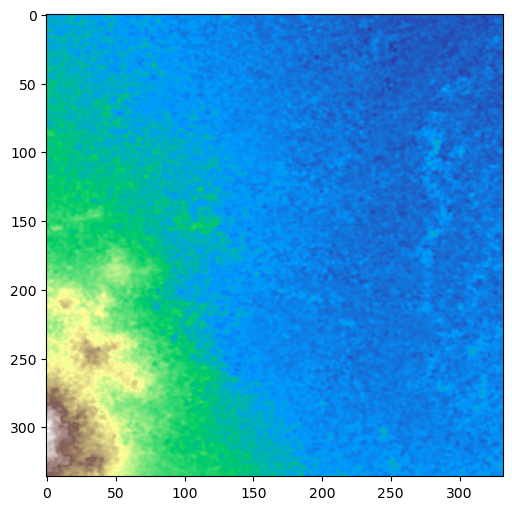

In [8]:
#papermill_description=processing

import io
from PIL import Image

req = json.loads(geojson)
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

stac_url_dem = "https://explorer.sandbox.dea.ga.gov.au/stac/"
stac_url_rgb = "https://earth-search.aws.element84.com/v1"
collections_dem = ['ga_srtm_dem1sv1_0']
collections_rgb = ['sentinel-2-l2a']

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

# Get bounding box from GeoJSON
bbox = get_bbox_from_geodf(geojson_data)

# Initialize STAC clients
#client_dem = initialize_stac_client(stac_url_dem)
client_rgb = initialize_stac_client(stac_url_rgb)

start_date = "2023-01-01"
end_date = "2023-03-01"

# Query STAC catalogs
#items_dem = query_stac_api(client_dem, bbox, collections_dem, None, None)
items_rgb = query_stac_api(client_rgb, bbox, collections_rgb, start_date, end_date)

# dem_results = process_dem_items(items_dem, geojson_data)


# Primary DEM asset URL from the STAC item
#dem_asset = item.assets.get('dem')
#primary_dem_href = dem_asset.href if dem_asset else None

# Fallback DEM URL
fallback_dem_href = 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'


def read_and_process_dem(href):
    with rasterio.open(href) as src:
        # Convert the GeoJSON bounds to a rasterio window
        window = from_bounds(*bbox, transform=src.transform)

        # Read the data within the window
        data = src.read(1, window=window)

        # Remove axes of length one from a.
        return np.squeeze(data)

data = read_and_process_dem(fallback_dem_href)

# image = Image.fromarray(data)

#plt.imshow(data, cmap='terrain')

image = Image.fromarray(data, mode='L')

image_filename = 'test-image.png'

figure = plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='terrain')
#plt.savefig('/tmp/test-image.png', format='png', dpi=300)
#plt.close()

figure.savefig('/tmp/test-image.png', bbox_inches='tight', pad_inches=0.05, transparent=False, dpi=280)

#elevation_stats = compute_elevation_statistics(data)

# Serialize elevation statistics to a JSON string
# elevation_stats_json = json.dumps(elevation_stats)
#elevation_stats_json = json.dumps(elevation_stats, default=lambda obj: float(obj) if isinstance(obj, np.float32) else None)

bucket_name = 'output'
# stats_filename = 'elevation_stats.json'

#s3_client.put_object(Bucket=bucket_name, Key=stats_filename, Body=elevation_stats_json)
#s3_client.upload_fileobj(image_buffer, bucket_name, image_filename)

# Close the image buffer
#image_buffer.close()


# with open('/tmp/image.png', 'wb') as image_file:
#     plt.imsave(image_file, data, cmap='terrain', format='png')

s3_client.upload_file('/tmp/test-image.png', bucket_name, image_filename)

print(f'Image uploaded to S3: http://localhost:9090/{bucket_name}/{image_filename}')


In [9]:
#papermill_description=display_output

from IPython.display import HTML


url = f'http://localhost:9090/{bucket_name}/{image_filename}'

print(url)

iframe = f'<iframe src="{url}" width="800" height="800"></iframe>'

HTML(iframe)

http://localhost:9090/output/test-image.png


/opt/conda/lib/python3.11/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
